In [1]:
from sklearn import preprocessing
import mguaJN
import numpy as np
import pandas as pd
from sklearn.metrics import r2_score, classification_report, roc_auc_score
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from numpy import random

In [12]:
# библиотеки для кластеризации
from metric_learn import MLKR
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.decomposition import PCA
import hdbscan
# import random

## Выборка bzr NNdb*_UpTo3chains
Посмотрим для каждого столбца Х распределение (хотим, чтобы оно было нормальным)

In [15]:
bzr = pd.read_csv('bzr/bzr_matrix_alphabet_NNdb*_UpTo3chains.csv', sep=',')
bzr_y = pd.read_csv('bzr/bzr_y.csv', sep=',')

In [16]:
for i, elem in bzr_y['IC50_uM'].items():
    bzr_y['IC50_uM'][i] = float(elem.strip('[]').strip('()').split(', ')[0])

In [17]:
normalized_bzr = preprocessing.normalize(bzr)
normalized_bzr.shape

(405, 357)

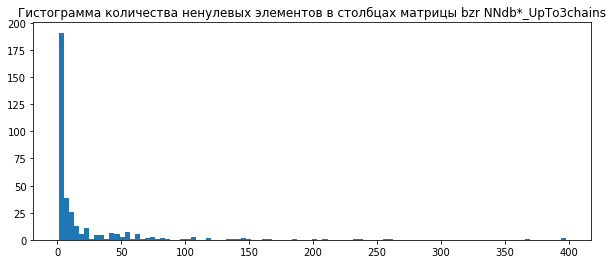

In [18]:
num_nonzero_col = []
for i in range(normalized_bzr.shape[1]):
    num_nonzero_col.append(normalized_bzr[:, i].nonzero()[0].shape[0])
plt.figure(figsize=(10,4))
plt.title("Гистограмма количества ненулевых элементов в столбцах матрицы bzr NNdb*_UpTo3chains")
_ = plt.hist(num_nonzero_col, bins=100)

In [117]:
mask = np.array(num_nonzero_col) == 1
mask.sum()

102

### Нормализация y
вычтем из y активность: для выборки bzr - это 0.1

In [19]:
bzr_y = bzr_y - 0.1

Попробуем использовать Гребневую регрессию с регуляризацией. Перед этим необходимо сделать стандартизацию матрицы X (предобработку данных, после которой каждый признак имеет среднее 0 и дисперсию 1.)

In [119]:
mgua_model = mguaJN.MGUA(Q=20, C=0.6, I=10, model=Ridge(alpha=0.1))

In [120]:
train_size = int(0.7 * bzr.shape[0])
X_train = pd.DataFrame(preprocessing.scale(bzr[:][:train_size]))
y_train = bzr_y[:][:train_size]
X_test = pd.DataFrame(preprocessing.scale(bzr[:][train_size:]))
y_test = bzr_y[:][train_size:]
mgua_model.fit(X_train, y_train)
res = np.array(mgua_model.predict(X_test))
res_train = np.array(mgua_model.predict(X_train))
res = res.reshape(len(mgua_model.buf_coef[0]), X_test.shape[0]).mean(axis=0)
res_train = res_train.reshape(len(mgua_model.buf_coef[0]), X_train.shape[0]).mean(axis=0)
print("r2 score на тестовой выборке = ", r2_score(y_test, res))
print("r2 score на тренировочной выборке = ", r2_score(y_train, res_train))

r2 score на тестовой выборке =  -0.00787313926308486
r2 score на тренировочной выборке =  0.23008644456823413


In [121]:
y_np_test = y_test.to_numpy().reshape(-1)
y_sgn_test = [-1 if y_i <= 0 else 1 for y_i in y_np_test]

In [122]:
y_sgn_res = [-1 if y_i <= 0 else 1 for y_i in res]

Результаты классификации с помощью МГУА:

In [123]:
print(classification_report(y_sgn_test, y_sgn_res))

              precision    recall  f1-score   support

          -1       0.00      0.00      0.00        39
           1       0.67      0.96      0.79        83

    accuracy                           0.66       122
   macro avg       0.34      0.48      0.40       122
weighted avg       0.46      0.66      0.54       122



In [124]:
roc_auc_score(y_sgn_test, y_sgn_res)

0.4819277108433735

просто в результате получилось всего 3 отрицательных значения

Попробуем в МГУА подать вместо регрессионных ответов ответы для классификации:

In [134]:
bzr_np_y = bzr_y.to_numpy().reshape(-1)
bzr_class_y = pd.DataFrame([-1 if y_i <= 0 else 1 for y_i in bzr_np_y])

In [137]:
# train_size = int(0.7 * bzr.shape[0])
rand_fold = random.choice(np.arange(bzr.shape[0]).tolist(), train_size, False)
X_train = pd.DataFrame(preprocessing.scale(bzr[:].loc[rand_fold]))
y_train = bzr_class_y[:].loc[rand_fold]
X_test = pd.DataFrame(preprocessing.scale(bzr[:].loc[np.delete(np.arange(bzr.shape[0]), rand_fold)]))
y_test = bzr_class_y[:].loc[np.delete(np.arange(bzr.shape[0]), rand_fold)]
# X_train = pd.DataFrame(preprocessing.scale(bzr[:][:train_size]))
# y_train = bzr_class_y[:][:train_size]
# X_test = pd.DataFrame(preprocessing.scale(bzr[:][train_size:]))
# y_test = bzr_class_y[:][train_size:]
mgua_model.fit(X_train, y_train)
res = np.array(mgua_model.predict(X_test))
# res_train = np.array(mgua_model.predict(X_train))
res = res.reshape(len(mgua_model.buf_coef[0]), X_test.shape[0]).mean(axis=0)
# res_train = res_train.reshape(len(mgua_model.buf_coef[0]), X_train.shape[0]).mean(axis=0)
print("r2 score на тестовой выборке = ", r2_score(y_test, res))
# print("r2 score на тренировочной выборке = ", r2_score(y_train, res_train))
y_sgn_res = [-1 if y_i <= 0 else 1 for y_i in res]
print()
print(classification_report(y_test, y_sgn_res))
print()
print("roc_auc_score = ", roc_auc_score(y_test, y_sgn_res))

r2 score на тестовой выборке =  0.08948423390946392

              precision    recall  f1-score   support

          -1       0.56      1.00      0.72        64
           1       1.00      0.12      0.22        58

    accuracy                           0.58       122
   macro avg       0.78      0.56      0.47       122
weighted avg       0.77      0.58      0.48       122


roc_auc_score =  0.5603448275862069


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc28b96c750>]],
      dtype=object)

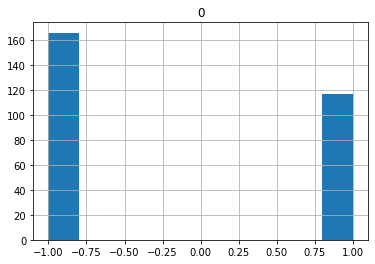

In [141]:
y_train.hist()

### Кластеризация

In [20]:
bzr_np_y = bzr_y.to_numpy().reshape(-1)
bzr_class_y = pd.DataFrame([-1 if y_i <= 0 else 1 for y_i in bzr_np_y])

In [47]:
train_size = int(0.7 * bzr.shape[0])
rand_fold = random.choice(np.arange(bzr.shape[0]).tolist(), train_size, False)
X_train = pd.DataFrame(preprocessing.scale(bzr[:].loc[rand_fold]))
y_train = bzr_class_y[:].loc[rand_fold]
X_test = pd.DataFrame(preprocessing.scale(bzr[:].loc[np.delete(np.arange(bzr.shape[0]), rand_fold)]))
y_test = bzr_class_y[:].loc[np.delete(np.arange(bzr.shape[0]), rand_fold)]

#### кластеризация с помощью метода к-средних

In [93]:
k = 3
min_elem_in_cluster = 25
clusters = KMeans(n_clusters=k)
clusters_train = clusters.fit_predict(X_train)

is_good_clusters = False
while is_good_clusters == False:
    clusters_train = clusters.fit_predict(X_train)
    elems_in_clusters = np.array([np.array([clusters_train == i]).sum() for i in np.unique(clusters_train)])
    elems_in_clusters_bool = elems_in_clusters > min_elem_in_cluster
    is_good_clusters = np.all(elems_in_clusters_bool)
print('Founded good clusters:', elems_in_clusters)
print()
clusters_test = clusters.predict(X_test)

for i in range(k):
    mgua_model = mguaJN.MGUA(Q=20, C=0.6, I=10, model=Ridge(alpha=0.1))
    mgua_model.fit(X_train.loc[clusters_train==i], y_train.loc[clusters_train==i])
    if X_test.loc[clusters_test==i].shape[0] > 0:
        res = np.array(mgua_model.predict(X_test.loc[clusters_test==i]))
        res = res.reshape(len(mgua_model.buf_coef[0]), X_test.loc[clusters_test==i].shape[0]).mean(axis=0)
        print("CLUSTER #", i)
        print()
        print("r2 score на тестовой выборке = ", r2_score(y_test.loc[clusters_test==i], res))
        y_sgn_res = [-1 if y_i <= 0 else 1 for y_i in res]
        print()
        print(classification_report(y_test.loc[clusters_test==i], y_sgn_res))
    else:
        print("CLUSTER #", i)
        print("No elements in test")
#     print()
#     print("roc_auc_score = ", roc_auc_score(y_test.loc[clusters_test==i], y_sgn_res))

Founded good clusters: [ 35  80 168]



CLUSTER # 0

r2 score на тестовой выборке =  -0.15953553403471576

              precision    recall  f1-score   support

          -1       0.91      1.00      0.95        20
           1       0.00      0.00      0.00         2

    accuracy                           0.91        22
   macro avg       0.45      0.50      0.48        22
weighted avg       0.83      0.91      0.87        22



/Users/Varya/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


CLUSTER # 1

r2 score на тестовой выборке =  -0.021503159309249398

              precision    recall  f1-score   support

          -1       0.71      0.92      0.80        24
           1       0.50      0.18      0.27        11

    accuracy                           0.69        35
   macro avg       0.60      0.55      0.53        35
weighted avg       0.64      0.69      0.63        35



CLUSTER # 2

r2 score на тестовой выборке =  0.11163304757708759

              precision    recall  f1-score   support

          -1       0.78      0.60      0.68        30
           1       0.71      0.86      0.78        35

    accuracy                           0.74        65
   macro avg       0.75      0.73      0.73        65
weighted avg       0.75      0.74      0.73        65



Получилось, что в кластере 0 все метки предсказались как -1, в действительности же там только 2 молекулы из 65 в тестовой выборке имеют значение 1

In [98]:
y_test.loc[clusters_test==i].shape

(65, 1)

#### Кластеризация с помощью метода DBSCAN

In [100]:
train_size = int(0.7 * bzr.shape[0])
rand_fold = random.choice(np.arange(bzr.shape[0]).tolist(), train_size, False)
X_train = pd.DataFrame(preprocessing.scale(bzr[:].loc[rand_fold]))
y_train = bzr_class_y[:].loc[rand_fold]
X_test = pd.DataFrame(preprocessing.scale(bzr[:].loc[np.delete(np.arange(bzr.shape[0]), rand_fold)]))
y_test = bzr_class_y[:].loc[np.delete(np.arange(bzr.shape[0]), rand_fold)]

Подберем параметр эпсилон так, чтобы было как можно меньше точек отказа (-1), но чтобы все молекулы не отнеслись к одному классу (0 при eps=7.). Параметр min_samples означает минимальное количество точек в кластере 

(array([ 73.,   0.,   0., 152.,   0.,   0.,  30.,   0.,   0.,  28.]),
 array([-1. , -0.7, -0.4, -0.1,  0.2,  0.5,  0.8,  1.1,  1.4,  1.7,  2. ]),
 <a list of 10 Patch objects>)

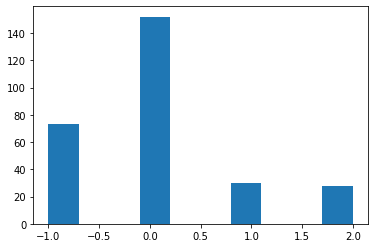

In [120]:
clusters = DBSCAN(eps=5.5, min_samples=30)
clusters_all = clusters.fit_predict(bzr)
clusters_train = clusters_all[rand_fold]
clusters_test = clusters_all[np.delete(np.arange(bzr.shape[0]), rand_fold)]
plt.hist(clusters_train)

In [124]:
np.unique(clusters.labels_)

array([-1,  0,  1,  2])

In [125]:
clusters = DBSCAN(eps=5.5, min_samples=30)
clusters_all = clusters.fit_predict(bzr)
clusters_train = clusters_all[rand_fold]
clusters_test = clusters_all[np.delete(np.arange(bzr.shape[0]), rand_fold)]

for i in np.unique(clusters.labels_):
    mgua_model = mguaJN.MGUA(Q=20, C=0.6, I=10, model=Ridge(alpha=0.1))
    mgua_model.fit(X_train.loc[clusters_train==i], y_train.loc[clusters_train==i])
    if X_test.loc[clusters_test==i].shape[0] > 0:
        res = np.array(mgua_model.predict(X_test.loc[clusters_test==i]))
        res = res.reshape(len(mgua_model.buf_coef[0]), X_test.loc[clusters_test==i].shape[0]).mean(axis=0)
        print("CLUSTER #", i)
        print()
        print("r2 score на тестовой выборке = ", r2_score(y_test.loc[clusters_test==i], res))
        y_sgn_res = [-1 if y_i <= 0 else 1 for y_i in res]
        print()
        print(classification_report(y_test.loc[clusters_test==i], y_sgn_res))
    else:
        print("CLUSTER #", i)
        print("No elements in test")

CLUSTER # -1

r2 score на тестовой выборке =  0.2600961817778642

              precision    recall  f1-score   support

          -1       0.89      0.89      0.89        18
           1       0.86      0.86      0.86        14

    accuracy                           0.88        32
   macro avg       0.87      0.87      0.87        32
weighted avg       0.88      0.88      0.88        32



CLUSTER # 0

r2 score на тестовой выборке =  0.08239018190652148

              precision    recall  f1-score   support

          -1       0.66      0.79      0.72        29
           1       0.65      0.48      0.55        23

    accuracy                           0.65        52
   macro avg       0.65      0.64      0.63        52
weighted avg       0.65      0.65      0.64        52



CLUSTER # 1

r2 score на тестовой выборке =  -0.5504761904761901

              precision    recall  f1-score   support

          -1       0.95      1.00      0.98        21
           1       0.00      0.00      0.00         1

    accuracy                           0.95        22
   macro avg       0.48      0.50      0.49        22
weighted avg       0.91      0.95      0.93        22



/Users/Varya/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


CLUSTER # 2

r2 score на тестовой выборке =  0.0871422137061505

              precision    recall  f1-score   support

          -1       0.62      0.71      0.67         7
           1       0.75      0.67      0.71         9

    accuracy                           0.69        16
   macro avg       0.69      0.69      0.69        16
weighted avg       0.70      0.69      0.69        16



### Метод главных компонент и DBSCAN

In [126]:
from sklearn.decomposition import PCA

In [173]:
pca = PCA(n_components=10)
bzr_pca = pd.DataFrame(pca.fit_transform(bzr))

train_size = int(0.7 * bzr_pca.shape[0])
rand_fold = random.choice(np.arange(bzr_pca.shape[0]).tolist(), train_size, False)
X_train = pd.DataFrame(preprocessing.scale(bzr_pca[:].loc[rand_fold]))
y_train = bzr_class_y[:].loc[rand_fold]
X_test = pd.DataFrame(preprocessing.scale(bzr_pca[:].loc[np.delete(np.arange(bzr_pca.shape[0]), rand_fold)]))
y_test = bzr_class_y[:].loc[np.delete(np.arange(bzr_pca.shape[0]), rand_fold)]

In [174]:
clusters = DBSCAN(eps=5.8, min_samples=30)
clusters_all = clusters.fit_predict(bzr)
clusters_train = clusters_all[rand_fold]
clusters_test = clusters_all[np.delete(np.arange(bzr.shape[0]), rand_fold)]

for i in np.unique(clusters.labels_):
    mgua_model = mguaJN.MGUA(Q=20, C=0.6, I=10, model=Ridge(alpha=0.1))
    mgua_model.fit(X_train.loc[clusters_train==i], y_train.loc[clusters_train==i])
    if X_test.loc[clusters_test==i].shape[0] > 0:
        res = np.array(mgua_model.predict(X_test.loc[clusters_test==i]))
        res = res.reshape(len(mgua_model.buf_coef[0]), X_test.loc[clusters_test==i].shape[0]).mean(axis=0)
        print("CLUSTER #", i)
        print()
        print("r2 score на тестовой выборке = ", r2_score(y_test.loc[clusters_test==i], res))
        y_sgn_res = [-1 if y_i <= 0 else 1 for y_i in res]
        print()
        print(classification_report(y_test.loc[clusters_test==i], y_sgn_res))
    else:
        print("CLUSTER #", i)
        print("No elements in test")

CLUSTER # -1

r2 score на тестовой выборке =  0.11922648822901627

              precision    recall  f1-score   support

          -1       0.67      0.89      0.76         9
           1       0.89      0.67      0.76        12

    accuracy                           0.76        21
   macro avg       0.78      0.78      0.76        21
weighted avg       0.79      0.76      0.76        21



CLUSTER # 0

r2 score на тестовой выборке =  0.10558704880325387

              precision    recall  f1-score   support

          -1       0.67      0.79      0.73        42
           1       0.62      0.48      0.55        31

    accuracy                           0.66        73
   macro avg       0.65      0.63      0.64        73
weighted avg       0.65      0.66      0.65        73



CLUSTER # 1

r2 score на тестовой выборке =  0.2117448688608784

              precision    recall  f1-score   support

          -1       0.81      1.00      0.90        13
           1       0.00      0.00      0.00         3

    accuracy                           0.81        16
   macro avg       0.41      0.50      0.45        16
weighted avg       0.66      0.81      0.73        16



/Users/Varya/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


CLUSTER # 2

r2 score на тестовой выборке =  0.14507667615619912

              precision    recall  f1-score   support

          -1       0.57      1.00      0.73         4
           1       1.00      0.62      0.77         8

    accuracy                           0.75        12
   macro avg       0.79      0.81      0.75        12
weighted avg       0.86      0.75      0.76        12



## Выборка bzr NNd**_UpTo3chains


In [175]:
bzr = pd.read_csv('bzr/bzr_matrix_alphabet_NNd**_UpTo3chains.csv', sep=',')
bzr_y = pd.read_csv('bzr/bzr_y.csv', sep=',')

In [176]:
for i, elem in bzr_y['IC50_uM'].items():
    bzr_y['IC50_uM'][i] = float(elem.strip('[]').strip('()').split(', ')[0])

In [151]:
normalized_bzr = preprocessing.normalize(bzr)
normalized_bzr.shape

(405, 138)

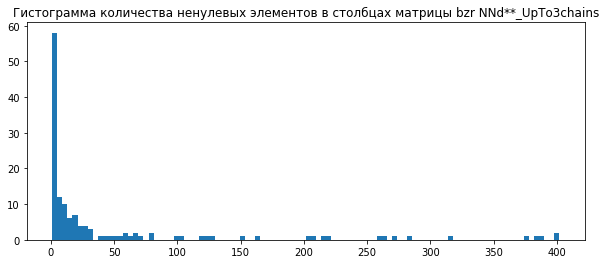

In [152]:
num_nonzero_col = []
for i in range(normalized_bzr.shape[1]):
    num_nonzero_col.append(normalized_bzr[:, i].nonzero()[0].shape[0])
plt.figure(figsize=(10,4))
plt.title("Гистограмма количества ненулевых элементов в столбцах матрицы bzr NNd**_UpTo3chains")
_ = plt.hist(num_nonzero_col, bins=100)

In [153]:
mask = np.array(num_nonzero_col) == 1
print("количество столбцов с одним ненулевым элементом = ", mask.sum(), "/", (~mask).sum())

количество столбцов с одним ненулевым элементом =  26 / 112


### Нормализация y

In [177]:
bzr_y = bzr_y - 0.1

In [155]:
mgua_model = mguaJN.MGUA(Q=20, C=0.6, I=10, model=Ridge(alpha=0.1))

In [156]:
train_size = int(0.7 * bzr.shape[0])
X_train = pd.DataFrame(preprocessing.scale(bzr[:][:train_size]))
y_train = bzr_y[:][:train_size]
X_test = pd.DataFrame(preprocessing.scale(bzr[:][train_size:]))
y_test = bzr_y[:][train_size:]
mgua_model.fit(X_train, y_train)
res = np.array(mgua_model.predict(X_test))
res_train = np.array(mgua_model.predict(X_train))
res = res.reshape(len(mgua_model.buf_coef[0]), X_test.shape[0]).mean(axis=0)
res_train = res_train.reshape(len(mgua_model.buf_coef[0]), X_train.shape[0]).mean(axis=0)
print("r2 score на тестовой выборке = ", r2_score(y_test, res))
print("r2 score на тренировочной выборке = ", r2_score(y_train, res_train))

r2 score на тестовой выборке =  -0.0001987325388648209
r2 score на тренировочной выборке =  0.23519308554758978


In [157]:
y_np_test = y_test.to_numpy().reshape(-1)
y_sgn_test = [-1 if y_i <= 0 else 1 for y_i in y_np_test]
y_sgn_res = [-1 if y_i <= 0 else 1 for y_i in res]

In [158]:
print(classification_report(y_sgn_test, y_sgn_res))
print("roc_auc_score = ", roc_auc_score(y_sgn_test, y_sgn_res))

              precision    recall  f1-score   support

          -1       0.10      0.03      0.04        39
           1       0.66      0.89      0.76        83

    accuracy                           0.61       122
   macro avg       0.38      0.46      0.40       122
weighted avg       0.48      0.61      0.53       122

roc_auc_score =  0.4586036453506333


Подадим в МГУА ответы для классификации:

In [159]:
bzr_np_y = bzr_y.to_numpy().reshape(-1)
bzr_class_y = pd.DataFrame([-1 if y_i <= 0 else 1 for y_i in bzr_np_y])

In [168]:
# train_size = int(0.7 * bzr.shape[0])
rand_fold = random.choice(np.arange(bzr.shape[0]).tolist(), train_size, False)
X_train = pd.DataFrame(preprocessing.scale(bzr[:].loc[rand_fold]))
y_train = bzr_class_y[:].loc[rand_fold]
X_test = pd.DataFrame(preprocessing.scale(bzr[:].loc[np.delete(np.arange(bzr.shape[0]), rand_fold)]))
y_test = bzr_class_y[:].loc[np.delete(np.arange(bzr.shape[0]), rand_fold)]
# X_train = pd.DataFrame(preprocessing.scale(bzr[:][:train_size]))
# y_train = bzr_class_y[:][:train_size]
# X_test = pd.DataFrame(preprocessing.scale(bzr[:][train_size:]))
# y_test = bzr_class_y[:][train_size:]
mgua_model.fit(X_train, y_train)
res = np.array(mgua_model.predict(X_test))
# res_train = np.array(mgua_model.predict(X_train))
res = res.reshape(res.shape[0], res.shape[1]).mean(axis=0)
# res_train = res_train.reshape(len(mgua_model.buf_coef[0]), X_train.shape[0]).mean(axis=0)
print("r2 score на тестовой выборке = ", r2_score(y_test, res))
# print("r2 score на тренировочной выборке = ", r2_score(y_train, res_train))
y_sgn_res = [-1 if y_i <= 0 else 1 for y_i in res]
print()
print(classification_report(y_test, y_sgn_res))
print()
print("roc_auc_score = ", roc_auc_score(y_test, y_sgn_res))

r2 score на тестовой выборке =  0.07218647175050374

              precision    recall  f1-score   support

          -1       0.53      1.00      0.70        63
           1       1.00      0.07      0.13        59

    accuracy                           0.55       122
   macro avg       0.77      0.53      0.41       122
weighted avg       0.76      0.55      0.42       122


roc_auc_score =  0.5338983050847458


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc289de0150>]],
      dtype=object)

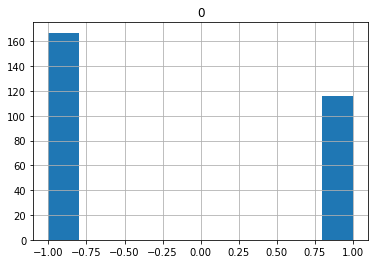

In [170]:
y_train.hist()

## Кластеризация

In [178]:
bzr_np_y = bzr_y.to_numpy().reshape(-1)
bzr_class_y = pd.DataFrame([-1 if y_i <= 0 else 1 for y_i in bzr_np_y])

In [179]:
train_size = int(0.7 * bzr.shape[0])
rand_fold = random.choice(np.arange(bzr.shape[0]).tolist(), train_size, False)
X_train = pd.DataFrame(preprocessing.scale(bzr[:].loc[rand_fold]))
y_train = bzr_class_y[:].loc[rand_fold]
X_test = pd.DataFrame(preprocessing.scale(bzr[:].loc[np.delete(np.arange(bzr.shape[0]), rand_fold)]))
y_test = bzr_class_y[:].loc[np.delete(np.arange(bzr.shape[0]), rand_fold)]

### Кластеризация с помощью метода к-средних

In [183]:
k = 3
min_elem_in_cluster = 25
clusters = KMeans(n_clusters=k)
clusters_train = clusters.fit_predict(X_train)

is_good_clusters = False
while is_good_clusters == False:
    clusters_train = clusters.fit_predict(X_train)
    elems_in_clusters = np.array([np.array([clusters_train == i]).sum() for i in np.unique(clusters_train)])
    elems_in_clusters_bool = elems_in_clusters > min_elem_in_cluster
    is_good_clusters = np.all(elems_in_clusters_bool)
print('Founded good clusters:', elems_in_clusters)
print()
clusters_test = clusters.predict(X_test)

for i in range(k):
    mgua_model = mguaJN.MGUA(Q=20, C=0.6, I=10, model=Ridge(alpha=0.1))
    mgua_model.fit(X_train.loc[clusters_train==i], y_train.loc[clusters_train==i])
    if X_test.loc[clusters_test==i].shape[0] > 0:
        res = np.array(mgua_model.predict(X_test.loc[clusters_test==i]))
        res = res.reshape(len(mgua_model.buf_coef[0]), X_test.loc[clusters_test==i].shape[0]).mean(axis=0)
        print("CLUSTER #", i)
        print()
        print("r2 score на тестовой выборке = ", r2_score(y_test.loc[clusters_test==i], res))
        y_sgn_res = [-1 if y_i <= 0 else 1 for y_i in res]
        print()
        print(classification_report(y_test.loc[clusters_test==i], y_sgn_res))
    else:
        print("CLUSTER #", i)
        print("No elements in test")

Founded good clusters: [ 29  45 209]



CLUSTER # 0

r2 score на тестовой выборке =  0.13252059131724658

              precision    recall  f1-score   support

          -1       0.67      1.00      0.80         4
           1       1.00      0.33      0.50         3

    accuracy                           0.71         7
   macro avg       0.83      0.67      0.65         7
weighted avg       0.81      0.71      0.67         7



CLUSTER # 1

r2 score на тестовой выборке =  0.008438370193681877

              precision    recall  f1-score   support

          -1       0.88      1.00      0.93        14
           1       0.00      0.00      0.00         2

    accuracy                           0.88        16
   macro avg       0.44      0.50      0.47        16
weighted avg       0.77      0.88      0.82        16



/Users/Varya/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


CLUSTER # 2

r2 score на тестовой выборке =  0.06399600593794563

              precision    recall  f1-score   support

          -1       0.60      0.56      0.58        48
           1       0.61      0.65      0.63        51

    accuracy                           0.61        99
   macro avg       0.61      0.60      0.60        99
weighted avg       0.61      0.61      0.61        99



### Кластеризация с помощью метода DBSCAN

In [184]:
train_size = int(0.7 * bzr.shape[0])
rand_fold = random.choice(np.arange(bzr.shape[0]).tolist(), train_size, False)
X_train = pd.DataFrame(preprocessing.scale(bzr[:].loc[rand_fold]))
y_train = bzr_class_y[:].loc[rand_fold]
X_test = pd.DataFrame(preprocessing.scale(bzr[:].loc[np.delete(np.arange(bzr.shape[0]), rand_fold)]))
y_test = bzr_class_y[:].loc[np.delete(np.arange(bzr.shape[0]), rand_fold)]

(array([ 34.,   0.,   0.,   0.,   0., 212.,   0.,   0.,   0.,  37.]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]),
 <a list of 10 Patch objects>)

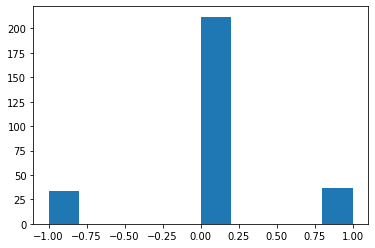

In [196]:
clusters = DBSCAN(eps=5.5, min_samples=30)
clusters_all = clusters.fit_predict(bzr)
clusters_train = clusters_all[rand_fold]
clusters_test = clusters_all[np.delete(np.arange(bzr.shape[0]), rand_fold)]
plt.hist(clusters_train)

In [197]:
clusters = DBSCAN(eps=5.5, min_samples=30)
clusters_all = clusters.fit_predict(bzr)
clusters_train = clusters_all[rand_fold]
clusters_test = clusters_all[np.delete(np.arange(bzr.shape[0]), rand_fold)]

for i in np.unique(clusters.labels_):
    mgua_model = mguaJN.MGUA(Q=20, C=0.6, I=10, model=Ridge(alpha=0.1))
    mgua_model.fit(X_train.loc[clusters_train==i], y_train.loc[clusters_train==i])
    if X_test.loc[clusters_test==i].shape[0] > 0:
        res = np.array(mgua_model.predict(X_test.loc[clusters_test==i]))
        res = res.reshape(len(mgua_model.buf_coef[0]), X_test.loc[clusters_test==i].shape[0]).mean(axis=0)
        print("CLUSTER #", i)
        print()
        print("r2 score на тестовой выборке = ", r2_score(y_test.loc[clusters_test==i], res))
        y_sgn_res = [-1 if y_i <= 0 else 1 for y_i in res]
        print()
        print(classification_report(y_test.loc[clusters_test==i], y_sgn_res))
    else:
        print("CLUSTER #", i)
        print("No elements in test")

CLUSTER # -1

r2 score на тестовой выборке =  0.4403903479332085

              precision    recall  f1-score   support

          -1       0.86      1.00      0.92         6
           1       1.00      0.75      0.86         4

    accuracy                           0.90        10
   macro avg       0.93      0.88      0.89        10
weighted avg       0.91      0.90      0.90        10



CLUSTER # 0

r2 score на тестовой выборке =  -0.0673800646285665

              precision    recall  f1-score   support

          -1       0.43      0.90      0.58        39
           1       0.73      0.19      0.30        58

    accuracy                           0.47        97
   macro avg       0.58      0.54      0.44        97
weighted avg       0.61      0.47      0.41        97



CLUSTER # 1

r2 score на тестовой выборке =  -2.8094622689156523e-05

              precision    recall  f1-score   support

          -1       0.87      1.00      0.93        13
           1       0.00      0.00      0.00         2

    accuracy                           0.87        15
   macro avg       0.43      0.50      0.46        15
weighted avg       0.75      0.87      0.80        15



/Users/Varya/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Метод главных компонент и DBSCAN

In [217]:
pca = PCA(n_components=9)
bzr_pca = pd.DataFrame(pca.fit_transform(bzr))

train_size = int(0.7 * bzr_pca.shape[0])
rand_fold = random.choice(np.arange(bzr_pca.shape[0]).tolist(), train_size, False)
X_train = pd.DataFrame(preprocessing.scale(bzr_pca[:].loc[rand_fold]))
y_train = bzr_class_y[:].loc[rand_fold]
X_test = pd.DataFrame(preprocessing.scale(bzr_pca[:].loc[np.delete(np.arange(bzr_pca.shape[0]), rand_fold)]))
y_test = bzr_class_y[:].loc[np.delete(np.arange(bzr_pca.shape[0]), rand_fold)]

CLUSTER # -1

r2 score на тестовой выборке =  -0.2527858374930241

              precision    recall  f1-score   support

          -1       0.47      1.00      0.64         7
           1       0.00      0.00      0.00         8

    accuracy                           0.47        15
   macro avg       0.23      0.50      0.32        15
weighted avg       0.22      0.47      0.30        15



/Users/Varya/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


CLUSTER # 0

r2 score на тестовой выборке =  0.012369903494924506

              precision    recall  f1-score   support

          -1       0.48      0.93      0.63        40
           1       0.75      0.18      0.30        49

    accuracy                           0.52        89
   macro avg       0.62      0.55      0.46        89
weighted avg       0.63      0.52      0.45        89



CLUSTER # 1

r2 score на тестовой выборке =  0.20691397607674067

              precision    recall  f1-score   support

          -1       0.78      1.00      0.88        14
           1       0.00      0.00      0.00         4

    accuracy                           0.78        18
   macro avg       0.39      0.50      0.44        18
weighted avg       0.60      0.78      0.68        18



/Users/Varya/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


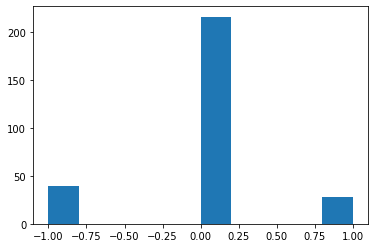

In [218]:
clusters = DBSCAN(eps=5.3, min_samples=30)
clusters_all = clusters.fit_predict(bzr)
clusters_train = clusters_all[rand_fold]
clusters_test = clusters_all[np.delete(np.arange(bzr.shape[0]), rand_fold)]
plt.hist(clusters_train)

for i in np.unique(clusters.labels_):
    mgua_model = mguaJN.MGUA(Q=20, C=0.6, I=10, model=Ridge(alpha=0.1))
    mgua_model.fit(X_train.loc[clusters_train==i], y_train.loc[clusters_train==i])
    if X_test.loc[clusters_test==i].shape[0] > 0:
        res = np.array(mgua_model.predict(X_test.loc[clusters_test==i]))
        res = res.reshape(len(mgua_model.buf_coef[0]), X_test.loc[clusters_test==i].shape[0]).mean(axis=0)
        print("CLUSTER #", i)
        print()
        print("r2 score на тестовой выборке = ", r2_score(y_test.loc[clusters_test==i], res))
        y_sgn_res = [-1 if y_i <= 0 else 1 for y_i in res]
        print()
        print(classification_report(y_test.loc[clusters_test==i], y_sgn_res))
    else:
        print("CLUSTER #", i)
        print("No elements in test")

## Выборка cox2 NNdb*_UpTo3chains

In [3]:
cox = pd.read_csv('cox2/cox2_matrix_alphabet_NNdb*_UpTo3chains.csv', sep=',')
cox_y = pd.read_csv('cox2/cox2_y.csv', sep=',')

In [4]:
for i, elem in cox_y['IC50_uM'].items():
    cox_y['IC50_uM'][i] = float(elem.strip('[]').strip('()').split(', ')[0])

In [5]:
normalized_cox = preprocessing.normalize(cox)
normalized_cox.shape

(467, 256)

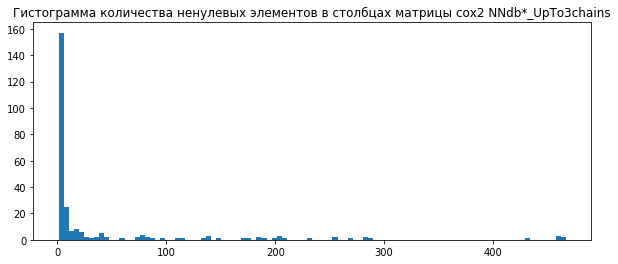

In [6]:
num_nonzero_col = []
for i in range(normalized_cox.shape[1]):
    num_nonzero_col.append(normalized_cox[:, i].nonzero()[0].shape[0])
plt.figure(figsize=(10,4))
plt.title("Гистограмма количества ненулевых элементов в столбцах матрицы cox2 NNdb*_UpTo3chains")
_ = plt.hist(num_nonzero_col, bins=100)

In [7]:
mask = np.array(num_nonzero_col) == 1
print("количество столбцов с одним ненулевым элементом = ", mask.sum(), "/", (~mask).sum())

количество столбцов с одним ненулевым элементом =  74 / 182


### Нормализация y

Вычтем из y порог активности. Для cox2 - 0.316

In [8]:
cox_y = cox_y - 0.316

In [208]:
mgua_model = mguaJN.MGUA(Q=20, C=0.6, I=10, model=Ridge(alpha=0.1))

In [209]:
train_size = int(0.7 * cox.shape[0])
X_train = pd.DataFrame(preprocessing.scale(cox[:][:train_size]))
y_train = cox_y[:][:train_size]
X_test = pd.DataFrame(preprocessing.scale(cox[:][train_size:]))
y_test = cox_y[:][train_size:]
mgua_model.fit(X_train, y_train)
res = np.array(mgua_model.predict(X_test))
res_train = np.array(mgua_model.predict(X_train))
res = res.reshape(len(mgua_model.buf_coef[0]), X_test.shape[0]).mean(axis=0)
res_train = res_train.reshape(len(mgua_model.buf_coef[0]), X_train.shape[0]).mean(axis=0)
print("r2 score на тестовой выборке = ", r2_score(y_test, res))
print("r2 score на тренировочной выборке = ", r2_score(y_train, res_train))

r2 score на тестовой выборке =  0.00321217683734909
r2 score на тренировочной выборке =  0.004892922530684296


In [10]:
y_np_test = y_test.to_numpy().reshape(-1)
y_sgn_test = [-1 if y_i <= 0 else 1 for y_i in y_np_test]
y_sgn_res = [-1 if y_i <= 0 else 1 for y_i in res]

In [211]:
print(classification_report(y_sgn_test, y_sgn_res))
print("roc_auc_score = ", roc_auc_score(y_sgn_test, y_sgn_res))

              precision    recall  f1-score   support

          -1       0.00      0.00      0.00        98
           1       0.30      1.00      0.47        43

    accuracy                           0.30       141
   macro avg       0.15      0.50      0.23       141
weighted avg       0.09      0.30      0.14       141

roc_auc_score =  0.5


/Users/Varya/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Подадим в МГУА ответы для классификации:

In [212]:
cox_np_y = cox_y.to_numpy().reshape(-1)
cox_class_y = pd.DataFrame([-1 if y_i <= 0 else 1 for y_i in cox_np_y])

In [182]:
train_size = int(0.7 * cox.shape[0])
rand_fold = random.choice(np.arange(cox.shape[0]).tolist(), train_size, False)
X_train = pd.DataFrame(preprocessing.scale(cox[:].loc[rand_fold]))
y_train = cox_class_y[:].loc[rand_fold]
X_test = pd.DataFrame(preprocessing.scale(cox[:].loc[np.delete(np.arange(cox.shape[0]), rand_fold)]))
y_test = cox_class_y[:].loc[np.delete(np.arange(cox.shape[0]), rand_fold)]
# X_train = pd.DataFrame(preprocessing.scale(bzr[:][:train_size]))
# y_train = bzr_class_y[:][:train_size]
# X_test = pd.DataFrame(preprocessing.scale(bzr[:][train_size:]))
# y_test = bzr_class_y[:][train_size:]
mgua_model.fit(X_train, y_train)
res = np.array(mgua_model.predict(X_test))
# res_train = np.array(mgua_model.predict(X_train))
res = res.reshape(res.shape[0], res.shape[1]).mean(axis=0)
# res_train = res_train.reshape(len(mgua_model.buf_coef[0]), X_train.shape[0]).mean(axis=0)
print("r2 score на тестовой выборке = ", r2_score(y_test, res))
# print("r2 score на тренировочной выборке = ", r2_score(y_train, res_train))
y_sgn_res = [-1 if y_i <= 0 else 1 for y_i in res]
print()
print(classification_report(y_test, y_sgn_res))
print()
print("roc_auc_score = ", roc_auc_score(y_test, y_sgn_res))

r2 score на тестовой выборке =  0.08198215633891992

              precision    recall  f1-score   support

          -1       0.59      0.99      0.74       103
           1       0.90      0.11      0.20        81

    accuracy                           0.60       184
   macro avg       0.74      0.55      0.47       184
weighted avg       0.72      0.60      0.50       184


roc_auc_score =  0.5507011866235167


# Кластеризация

In [14]:
cox_np_y = cox_y.to_numpy().reshape(-1)
cox_class_y = pd.DataFrame([-1 if y_i <= 0 else 1 for y_i in cox_np_y])

In [15]:
train_size = int(0.7 * cox.shape[0])
rand_fold = random.choice(np.arange(cox.shape[0]).tolist(), train_size, False)
X_train = pd.DataFrame(preprocessing.scale(cox[:].loc[rand_fold]))
y_train = cox_class_y[:].loc[rand_fold]
X_test = pd.DataFrame(preprocessing.scale(cox[:].loc[np.delete(np.arange(cox.shape[0]), rand_fold)]))
y_test = cox_class_y[:].loc[np.delete(np.arange(cox.shape[0]), rand_fold)]

## Кластеризация с помощью метода к-средних

In [225]:
k = 3
min_elem_in_cluster = 25
clusters = KMeans(n_clusters=k)
clusters_train = clusters.fit_predict(X_train)

is_good_clusters = False
while is_good_clusters == False:
    clusters_train = clusters.fit_predict(X_train)
    elems_in_clusters = np.array([np.array([clusters_train == i]).sum() for i in np.unique(clusters_train)])
    elems_in_clusters_bool = elems_in_clusters > min_elem_in_cluster
    is_good_clusters = np.all(elems_in_clusters_bool)
print('Founded good clusters:', elems_in_clusters)
print()
clusters_test = clusters.predict(X_test)

for i in range(k):
    mgua_model = mguaJN.MGUA(Q=20, C=0.6, I=10, model=Ridge(alpha=0.1))
    mgua_model.fit(X_train.loc[clusters_train==i], y_train.loc[clusters_train==i])
    if X_test.loc[clusters_test==i].shape[0] > 0:
        res = np.array(mgua_model.predict(X_test.loc[clusters_test==i]))
        res = res.reshape(len(mgua_model.buf_coef[0]), X_test.loc[clusters_test==i].shape[0]).mean(axis=0)
        print("CLUSTER #", i)
        print()
        print("r2 score на тестовой выборке = ", r2_score(y_test.loc[clusters_test==i], res))
        y_sgn_res = [-1 if y_i <= 0 else 1 for y_i in res]
        print()
        print(classification_report(y_test.loc[clusters_test==i], y_sgn_res))
    else:
        print("CLUSTER #", i)
        print("No elements in test")

Founded good clusters: [ 91  79 156]



CLUSTER # 0

r2 score на тестовой выборке =  0.10002237581364903

              precision    recall  f1-score   support

          -1       1.00      0.21      0.35        19
           1       0.66      1.00      0.79        29

    accuracy                           0.69        48
   macro avg       0.83      0.61      0.57        48
weighted avg       0.79      0.69      0.62        48



CLUSTER # 1

r2 score на тестовой выборке =  0.0025745009838059607

              precision    recall  f1-score   support

          -1       0.83      0.50      0.62        20
           1       0.50      0.83      0.62        12

    accuracy                           0.62        32
   macro avg       0.67      0.67      0.62        32
weighted avg       0.71      0.62      0.62        32



CLUSTER # 2

r2 score на тестовой выборке =  0.0013713034092102117

              precision    recall  f1-score   support

          -1       0.69      1.00      0.82        42
           1       0.00      0.00      0.00        19

    accuracy                           0.69        61
   macro avg       0.34      0.50      0.41        61
weighted avg       0.47      0.69      0.56        61



/Users/Varya/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Кластеризация с помощью метода DBSCAN

In [226]:
train_size = int(0.7 * cox.shape[0])
rand_fold = random.choice(np.arange(cox.shape[0]).tolist(), train_size, False)
X_train = pd.DataFrame(preprocessing.scale(cox[:].loc[rand_fold]))
y_train = cox_class_y[:].loc[rand_fold]
X_test = pd.DataFrame(preprocessing.scale(cox[:].loc[np.delete(np.arange(cox.shape[0]), rand_fold)]))
y_test = cox_class_y[:].loc[np.delete(np.arange(cox.shape[0]), rand_fold)]

(array([ 71.,   0.,   0., 192.,   0.,   0.,  26.,   0.,   0.,  37.]),
 array([-1. , -0.7, -0.4, -0.1,  0.2,  0.5,  0.8,  1.1,  1.4,  1.7,  2. ]),
 <a list of 10 Patch objects>)

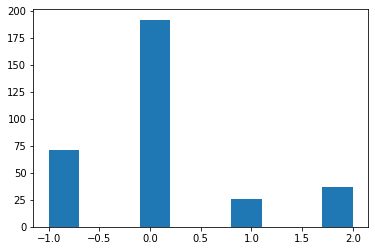

In [230]:
clusters = DBSCAN(eps=5.5, min_samples=30)
clusters_all = clusters.fit_predict(cox)
clusters_train = clusters_all[rand_fold]
clusters_test = clusters_all[np.delete(np.arange(cox.shape[0]), rand_fold)]
plt.hist(clusters_train)

In [231]:
clusters = DBSCAN(eps=5.5, min_samples=30)
clusters_all = clusters.fit_predict(cox)
clusters_train = clusters_all[rand_fold]
clusters_test = clusters_all[np.delete(np.arange(cox.shape[0]), rand_fold)]

for i in np.unique(clusters.labels_):
    mgua_model = mguaJN.MGUA(Q=20, C=0.6, I=10, model=Ridge(alpha=0.1))
    mgua_model.fit(X_train.loc[clusters_train==i], y_train.loc[clusters_train==i])
    if X_test.loc[clusters_test==i].shape[0] > 0:
        res = np.array(mgua_model.predict(X_test.loc[clusters_test==i]))
        res = res.reshape(len(mgua_model.buf_coef[0]), X_test.loc[clusters_test==i].shape[0]).mean(axis=0)
        print("CLUSTER #", i)
        print()
        print("r2 score на тестовой выборке = ", r2_score(y_test.loc[clusters_test==i], res))
        y_sgn_res = [-1 if y_i <= 0 else 1 for y_i in res]
        print()
        print(classification_report(y_test.loc[clusters_test==i], y_sgn_res))
    else:
        print("CLUSTER #", i)
        print("No elements in test")

CLUSTER # -1

r2 score на тестовой выборке =  -0.01684796918692788

              precision    recall  f1-score   support

          -1       0.79      1.00      0.89        31
           1       0.00      0.00      0.00         8

    accuracy                           0.79        39
   macro avg       0.40      0.50      0.44        39
weighted avg       0.63      0.79      0.70        39



/Users/Varya/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


CLUSTER # 0

r2 score на тестовой выборке =  0.019064266137154617

              precision    recall  f1-score   support

          -1       1.00      0.02      0.05        42
           1       0.47      1.00      0.64        36

    accuracy                           0.47        78
   macro avg       0.73      0.51      0.34        78
weighted avg       0.75      0.47      0.32        78



CLUSTER # 1

r2 score на тестовой выборке =  -0.2531434911242605

              precision    recall  f1-score   support

          -1       0.89      1.00      0.94         8
           1       0.00      0.00      0.00         1

    accuracy                           0.89         9
   macro avg       0.44      0.50      0.47         9
weighted avg       0.79      0.89      0.84         9



/Users/Varya/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


CLUSTER # 2

r2 score на тестовой выборке =  -0.055847001792947326

              precision    recall  f1-score   support

          -1       0.73      1.00      0.85        11
           1       0.00      0.00      0.00         4

    accuracy                           0.73        15
   macro avg       0.37      0.50      0.42        15
weighted avg       0.54      0.73      0.62        15



/Users/Varya/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Метод главных компонент и DBSCAN

In [16]:
pca = PCA(n_components=9)
cox_pca = pd.DataFrame(pca.fit_transform(cox))

train_size = int(0.7 * cox_pca.shape[0])
rand_fold = random.choice(np.arange(cox_pca.shape[0]).tolist(), train_size, False)
X_train = pd.DataFrame(preprocessing.scale(cox_pca[:].loc[rand_fold]))
y_train = cox_class_y[:].loc[rand_fold]
X_test = pd.DataFrame(preprocessing.scale(cox_pca[:].loc[np.delete(np.arange(cox_pca.shape[0]), rand_fold)]))
y_test = cox_class_y[:].loc[np.delete(np.arange(cox_pca.shape[0]), rand_fold)]

In [17]:
clusters = DBSCAN(eps=5.5, min_samples=30)
clusters_all = clusters.fit_predict(cox)
clusters_train = clusters_all[rand_fold]
clusters_test = clusters_all[np.delete(np.arange(cox.shape[0]), rand_fold)]

for i in np.unique(clusters.labels_):
    mgua_model = mguaJN.MGUA(Q=20, C=0.6, I=10, model=Ridge(alpha=0.1))
    mgua_model.fit(X_train.loc[clusters_train==i], y_train.loc[clusters_train==i])
    if X_test.loc[clusters_test==i].shape[0] > 0:
        res = np.array(mgua_model.predict(X_test.loc[clusters_test==i]))
        res = res.reshape(len(mgua_model.buf_coef[0]), X_test.loc[clusters_test==i].shape[0]).mean(axis=0)
        print("CLUSTER #", i)
        print()
        print("r2 score на тестовой выборке = ", r2_score(y_test.loc[clusters_test==i], res))
        y_sgn_res = [-1 if y_i <= 0 else 1 for y_i in res]
        print()
        print(classification_report(y_test.loc[clusters_test==i], y_sgn_res))
    else:
        print("CLUSTER #", i)
        print("No elements in test")

CLUSTER # -1

r2 score на тестовой выборке =  0.11635377048774187

              precision    recall  f1-score   support

          -1       0.68      1.00      0.81        21
           1       0.00      0.00      0.00        10

    accuracy                           0.68        31
   macro avg       0.34      0.50      0.40        31
weighted avg       0.46      0.68      0.55        31



/Users/Varya/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


CLUSTER # 0

r2 score на тестовой выборке =  0.0806215730414338

              precision    recall  f1-score   support

          -1       0.77      0.26      0.39        38
           1       0.58      0.93      0.72        42

    accuracy                           0.61        80
   macro avg       0.68      0.60      0.55        80
weighted avg       0.67      0.61      0.56        80



CLUSTER # 1

r2 score на тестовой выборке =  -0.13387214367296596

              precision    recall  f1-score   support

          -1       0.86      1.00      0.92        12
           1       0.00      0.00      0.00         2

    accuracy                           0.86        14
   macro avg       0.43      0.50      0.46        14
weighted avg       0.73      0.86      0.79        14



/Users/Varya/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


CLUSTER # 2

r2 score на тестовой выборке =  -0.01566691388960706

              precision    recall  f1-score   support

          -1       0.81      1.00      0.90        13
           1       0.00      0.00      0.00         3

    accuracy                           0.81        16
   macro avg       0.41      0.50      0.45        16
weighted avg       0.66      0.81      0.73        16



/Users/Varya/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(array([31.,  0.,  0., 80.,  0.,  0., 14.,  0.,  0., 16.]),
 array([-1. , -0.7, -0.4, -0.1,  0.2,  0.5,  0.8,  1.1,  1.4,  1.7,  2. ]),
 <a list of 10 Patch objects>)

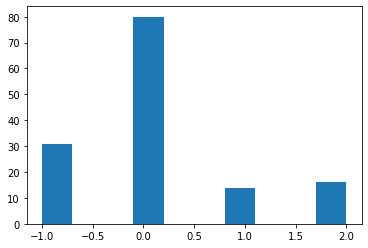

In [18]:
plt.hist(clusters_test)

## Выборка cox2 NNd**_UpTo3chains

In [19]:
cox = pd.read_csv('cox2/cox2_matrix_alphabet_NNd**_UpTo3chains.csv', sep=',')
cox_y = pd.read_csv('cox2/cox2_y.csv', sep=',')

In [20]:
for i, elem in cox_y['IC50_uM'].items():
    cox_y['IC50_uM'][i] = float(elem.strip('[]').strip('()').split(', ')[0])

In [21]:
normalized_cox = preprocessing.normalize(cox)
normalized_cox.shape

(467, 145)

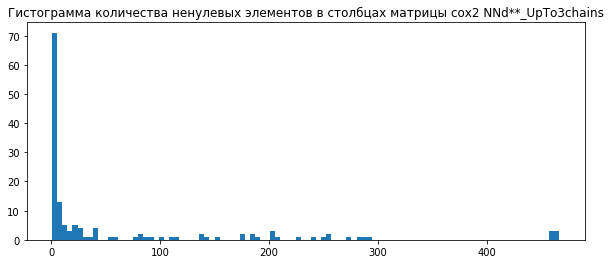

In [22]:
num_nonzero_col = []
for i in range(normalized_cox.shape[1]):
    num_nonzero_col.append(normalized_cox[:, i].nonzero()[0].shape[0])
plt.figure(figsize=(10,4))
plt.title("Гистограмма количества ненулевых элементов в столбцах матрицы cox2 NNd**_UpTo3chains")
_ = plt.hist(num_nonzero_col, bins=100)

In [23]:
mask = np.array(num_nonzero_col) == 1
print("количество столбцов с одним ненулевым элементом = ", mask.sum(), "/", (~mask).sum())

количество столбцов с одним ненулевым элементом =  30 / 115


### Нормализация y
вычтем из y активность: для выборки cox2 - это 0.316

In [24]:
cox_y = cox_y - 0.316

In [218]:
mgua_model = mguaJN.MGUA(Q=20, C=0.6, I=10, model=Ridge(alpha=0.1))

In [219]:
train_size = int(0.7 * cox.shape[0])
X_train = pd.DataFrame(preprocessing.scale(cox[:][:train_size]))
y_train = cox_y[:][:train_size]
X_test = pd.DataFrame(preprocessing.scale(cox[:][train_size:]))
y_test = cox_y[:][train_size:]
mgua_model.fit(X_train, y_train)
res = np.array(mgua_model.predict(X_test))
res_train = np.array(mgua_model.predict(X_train))
res = res.reshape(len(mgua_model.buf_coef[0]), X_test.shape[0]).mean(axis=0)
res_train = res_train.reshape(len(mgua_model.buf_coef[0]), X_train.shape[0]).mean(axis=0)
print("r2 score на тестовой выборке = ", r2_score(y_test, res))
print("r2 score на тренировочной выборке = ", r2_score(y_train, res_train))

r2 score на тестовой выборке =  0.00321217683734909
r2 score на тренировочной выборке =  0.004892922530684296


In [220]:
y_np_test = y_test.to_numpy().reshape(-1)
y_sgn_test = [-1 if y_i <= 0 else 1 for y_i in y_np_test]
y_sgn_res = [-1 if y_i <= 0 else 1 for y_i in res]

In [221]:
print(classification_report(y_sgn_test, y_sgn_res))
print("roc_auc_score = ", roc_auc_score(y_sgn_test, y_sgn_res))

              precision    recall  f1-score   support

          -1       0.00      0.00      0.00        98
           1       0.30      1.00      0.47        43

    accuracy                           0.30       141
   macro avg       0.15      0.50      0.23       141
weighted avg       0.09      0.30      0.14       141

roc_auc_score =  0.5


/Users/Varya/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Подадим в МГУА ответы для классификации:

In [193]:
cox_np_y = cox_y.to_numpy().reshape(-1)
cox_class_y = pd.DataFrame([-1 if y_i <= 0 else 1 for y_i in cox_np_y])

In [194]:
# train_size = int(0.7 * cox.shape[0])
rand_fold = random.choice(np.arange(cox.shape[0]).tolist(), train_size, False)
X_train = pd.DataFrame(preprocessing.scale(cox[:].loc[rand_fold]))
y_train = cox_class_y[:].loc[rand_fold]
X_test = pd.DataFrame(preprocessing.scale(cox[:].loc[np.delete(np.arange(cox.shape[0]), rand_fold)]))
y_test = cox_class_y[:].loc[np.delete(np.arange(cox.shape[0]), rand_fold)]
# X_train = pd.DataFrame(preprocessing.scale(bzr[:][:train_size]))
# y_train = bzr_class_y[:][:train_size]
# X_test = pd.DataFrame(preprocessing.scale(bzr[:][train_size:]))
# y_test = bzr_class_y[:][train_size:]
mgua_model.fit(X_train, y_train)
res = np.array(mgua_model.predict(X_test))
# res_train = np.array(mgua_model.predict(X_train))
res = res.reshape(res.shape[0], res.shape[1]).mean(axis=0)
# res_train = res_train.reshape(len(mgua_model.buf_coef[0]), X_train.shape[0]).mean(axis=0)
print("r2 score на тестовой выборке = ", r2_score(y_test, res))
# print("r2 score на тренировочной выборке = ", r2_score(y_train, res_train))
y_sgn_res = [-1 if y_i <= 0 else 1 for y_i in res]
print()
print(classification_report(y_test, y_sgn_res))
print()
print("roc_auc_score = ", roc_auc_score(y_test, y_sgn_res))

r2 score на тестовой выборке =  0.08929065737417263

              precision    recall  f1-score   support

          -1       0.58      1.00      0.73       102
           1       1.00      0.09      0.16        82

    accuracy                           0.59       184
   macro avg       0.79      0.54      0.44       184
weighted avg       0.77      0.59      0.48       184


roc_auc_score =  0.5426829268292683


# Кластеризация

In [25]:
cox_np_y = cox_y.to_numpy().reshape(-1)
cox_class_y = pd.DataFrame([-1 if y_i <= 0 else 1 for y_i in cox_np_y])

In [26]:
train_size = int(0.7 * cox.shape[0])
rand_fold = random.choice(np.arange(cox.shape[0]).tolist(), train_size, False)
X_train = pd.DataFrame(preprocessing.scale(cox[:].loc[rand_fold]))
y_train = cox_class_y[:].loc[rand_fold]
X_test = pd.DataFrame(preprocessing.scale(cox[:].loc[np.delete(np.arange(cox.shape[0]), rand_fold)]))
y_test = cox_class_y[:].loc[np.delete(np.arange(cox.shape[0]), rand_fold)]

## Кластеризация с помощью метода к-средних

In [27]:
k = 3
min_elem_in_cluster = 25
clusters = KMeans(n_clusters=k)
clusters_train = clusters.fit_predict(X_train)

is_good_clusters = False
while is_good_clusters == False:
    clusters_train = clusters.fit_predict(X_train)
    elems_in_clusters = np.array([np.array([clusters_train == i]).sum() for i in np.unique(clusters_train)])
    elems_in_clusters_bool = elems_in_clusters > min_elem_in_cluster
    is_good_clusters = np.all(elems_in_clusters_bool)
print('Founded good clusters:', elems_in_clusters)
print()
clusters_test = clusters.predict(X_test)

for i in range(k):
    mgua_model = mguaJN.MGUA(Q=20, C=0.6, I=10, model=Ridge(alpha=0.1))
    mgua_model.fit(X_train.loc[clusters_train==i], y_train.loc[clusters_train==i])
    if X_test.loc[clusters_test==i].shape[0] > 0:
        res = np.array(mgua_model.predict(X_test.loc[clusters_test==i]))
        res = res.reshape(len(mgua_model.buf_coef[0]), X_test.loc[clusters_test==i].shape[0]).mean(axis=0)
        print("CLUSTER #", i)
        print()
        print("r2 score на тестовой выборке = ", r2_score(y_test.loc[clusters_test==i], res))
        y_sgn_res = [-1 if y_i <= 0 else 1 for y_i in res]
        print()
        print(classification_report(y_test.loc[clusters_test==i], y_sgn_res))
    else:
        print("CLUSTER #", i)
        print("No elements in test")

Founded good clusters: [127 101  98]



CLUSTER # 0

r2 score на тестовой выборке =  0.006414197773224384

              precision    recall  f1-score   support

          -1       0.76      1.00      0.87        45
           1       0.00      0.00      0.00        14

    accuracy                           0.76        59
   macro avg       0.38      0.50      0.43        59
weighted avg       0.58      0.76      0.66        59



/Users/Varya/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


CLUSTER # 1

r2 score на тестовой выборке =  0.06375446164074194

              precision    recall  f1-score   support

          -1       0.67      0.64      0.65        22
           1       0.60      0.63      0.62        19

    accuracy                           0.63        41
   macro avg       0.63      0.63      0.63        41
weighted avg       0.64      0.63      0.63        41



CLUSTER # 2

r2 score на тестовой выборке =  0.12121326940763832

              precision    recall  f1-score   support

          -1       1.00      0.06      0.11        17
           1       0.60      1.00      0.75        24

    accuracy                           0.61        41
   macro avg       0.80      0.53      0.43        41
weighted avg       0.77      0.61      0.49        41



## Кластеризация с помощью метода DBSCAN

In [28]:
train_size = int(0.7 * cox.shape[0])
rand_fold = random.choice(np.arange(cox.shape[0]).tolist(), train_size, False)
X_train = pd.DataFrame(preprocessing.scale(cox[:].loc[rand_fold]))
y_train = cox_class_y[:].loc[rand_fold]
X_test = pd.DataFrame(preprocessing.scale(cox[:].loc[np.delete(np.arange(cox.shape[0]), rand_fold)]))
y_test = cox_class_y[:].loc[np.delete(np.arange(cox.shape[0]), rand_fold)

(array([ 28.,   0.,   0., 193.,   0.,   0.,  83.,   0.,   0.,  22.]),
 array([-1. , -0.7, -0.4, -0.1,  0.2,  0.5,  0.8,  1.1,  1.4,  1.7,  2. ]),
 <a list of 10 Patch objects>)

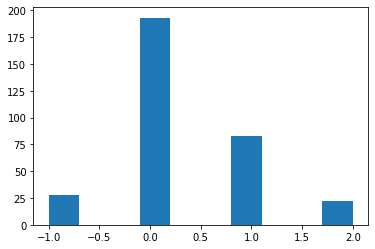

In [39]:
clusters = DBSCAN(eps=5.5, min_samples=30)
clusters_all = clusters.fit_predict(cox)
clusters_train = clusters_all[rand_fold]
clusters_test = clusters_all[np.delete(np.arange(cox.shape[0]), rand_fold)]
plt.hist(clusters_train)

In [40]:
clusters = DBSCAN(eps=5.5, min_samples=30)
clusters_all = clusters.fit_predict(cox)
clusters_train = clusters_all[rand_fold]
clusters_test = clusters_all[np.delete(np.arange(cox.shape[0]), rand_fold)]

for i in np.unique(clusters.labels_):
    mgua_model = mguaJN.MGUA(Q=20, C=0.6, I=10, model=Ridge(alpha=0.1))
    mgua_model.fit(X_train.loc[clusters_train==i], y_train.loc[clusters_train==i])
    if X_test.loc[clusters_test==i].shape[0] > 0:
        res = np.array(mgua_model.predict(X_test.loc[clusters_test==i]))
        res = res.reshape(len(mgua_model.buf_coef[0]), X_test.loc[clusters_test==i].shape[0]).mean(axis=0)
        print("CLUSTER #", i)
        print()
        print("r2 score на тестовой выборке = ", r2_score(y_test.loc[clusters_test==i], res))
        y_sgn_res = [-1 if y_i <= 0 else 1 for y_i in res]
        print()
        print(classification_report(y_test.loc[clusters_test==i], y_sgn_res))
    else:
        print("CLUSTER #", i)
        print("No elements in test")

CLUSTER # -1

r2 score на тестовой выборке =  -0.07717964434299618

              precision    recall  f1-score   support

          -1       0.85      1.00      0.92        11
           1       0.00      0.00      0.00         2

    accuracy                           0.85        13
   macro avg       0.42      0.50      0.46        13
weighted avg       0.72      0.85      0.78        13



/Users/Varya/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


CLUSTER # 0

r2 score на тестовой выборке =  0.07219123093333124

              precision    recall  f1-score   support

          -1       0.67      0.36      0.47        33
           1       0.67      0.88      0.76        49

    accuracy                           0.67        82
   macro avg       0.67      0.62      0.62        82
weighted avg       0.67      0.67      0.64        82



CLUSTER # 1

r2 score на тестовой выборке =  -0.02522839726326942

              precision    recall  f1-score   support

          -1       0.79      1.00      0.89        27
           1       0.00      0.00      0.00         7

    accuracy                           0.79        34
   macro avg       0.40      0.50      0.44        34
weighted avg       0.63      0.79      0.70        34



/Users/Varya/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


CLUSTER # 2

r2 score на тестовой выборке =  -0.0162309598822028

              precision    recall  f1-score   support

          -1       0.92      1.00      0.96        11
           1       0.00      0.00      0.00         1

    accuracy                           0.92        12
   macro avg       0.46      0.50      0.48        12
weighted avg       0.84      0.92      0.88        12



/Users/Varya/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Метод главных компонент и DBSCAN

In [41]:
pca = PCA(n_components=9)
cox_pca = pd.DataFrame(pca.fit_transform(cox))

train_size = int(0.7 * cox_pca.shape[0])
rand_fold = random.choice(np.arange(cox_pca.shape[0]).tolist(), train_size, False)
X_train = pd.DataFrame(preprocessing.scale(cox_pca[:].loc[rand_fold]))
y_train = cox_class_y[:].loc[rand_fold]
X_test = pd.DataFrame(preprocessing.scale(cox_pca[:].loc[np.delete(np.arange(cox_pca.shape[0]), rand_fold)]))
y_test = cox_class_y[:].loc[np.delete(np.arange(cox_pca.shape[0]), rand_fold)]

CLUSTER # -1

r2 score на тестовой выборке =  0.04043155225932338

              precision    recall  f1-score   support

          -1       0.84      1.00      0.91        16
           1       1.00      0.25      0.40         4

    accuracy                           0.85        20
   macro avg       0.92      0.62      0.66        20
weighted avg       0.87      0.85      0.81        20



CLUSTER # 0

r2 score на тестовой выборке =  -0.2544621946682346

              precision    recall  f1-score   support

          -1       0.29      0.13      0.18        15
           1       0.48      0.71      0.57        17

    accuracy                           0.44        32
   macro avg       0.38      0.42      0.38        32
weighted avg       0.39      0.44      0.39        32



CLUSTER # 1

r2 score на тестовой выборке =  0.05370228771136676

              precision    recall  f1-score   support

          -1       0.76      0.46      0.58        28
           1       0.59      0.85      0.70        26

    accuracy                           0.65        54
   macro avg       0.68      0.66      0.64        54
weighted avg       0.68      0.65      0.64        54



CLUSTER # 2

r2 score на тестовой выборке =  -0.20319643798159803

              precision    recall  f1-score   support

          -1       0.60      1.00      0.75        21
           1       0.00      0.00      0.00        14

    accuracy                           0.60        35
   macro avg       0.30      0.50      0.37        35
weighted avg       0.36      0.60      0.45        35



/Users/Varya/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


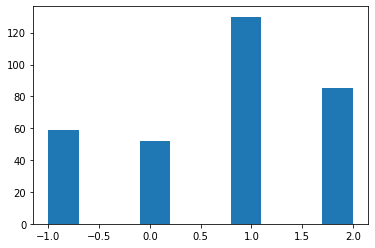

In [48]:
clusters = DBSCAN(eps=4.0, min_samples=30)
clusters_all = clusters.fit_predict(cox_pca)
clusters_train = clusters_all[rand_fold]
clusters_test = clusters_all[np.delete(np.arange(cox_pca.shape[0]), rand_fold)]

plt.hist(clusters_train)

for i in np.unique(clusters.labels_):
    mgua_model = mguaJN.MGUA(Q=20, C=0.6, I=10, model=Ridge(alpha=0.1))
    mgua_model.fit(X_train.loc[clusters_train==i], y_train.loc[clusters_train==i])
    if X_test.loc[clusters_test==i].shape[0] > 0:
        res = np.array(mgua_model.predict(X_test.loc[clusters_test==i]))
        res = res.reshape(len(mgua_model.buf_coef[0]), X_test.loc[clusters_test==i].shape[0]).mean(axis=0)
        print("CLUSTER #", i)
        print()
        print("r2 score на тестовой выборке = ", r2_score(y_test.loc[clusters_test==i], res))
        y_sgn_res = [-1 if y_i <= 0 else 1 for y_i in res]
        print()
        print(classification_report(y_test.loc[clusters_test==i], y_sgn_res))
    else:
        print("CLUSTER #", i)
        print("No elements in test")

## Выборка er_lit NNdb*_UpTo3chains


In [49]:
er = pd.read_csv('er_lit/er_lit_matrix_alphabet_NNdb*_UpTo3chains.csv', sep=',')
er_y = pd.read_csv('er_lit/er_lit_y.csv', sep=',')

In [50]:
normalized_er = preprocessing.normalize(er)
normalized_er.shape

(393, 331)

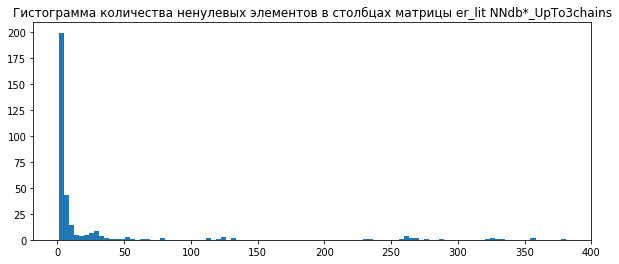

In [51]:
num_nonzero_col = []
for i in range(normalized_er.shape[1]):
    num_nonzero_col.append(normalized_er[:, i].nonzero()[0].shape[0])
plt.figure(figsize=(10,4))
plt.title("Гистограмма количества ненулевых элементов в столбцах матрицы er_lit NNdb*_UpTo3chains")
_ = plt.hist(num_nonzero_col, bins=100)

In [52]:
mask = np.array(num_nonzero_col) == 1
print("количество столбцов с одним ненулевым элементом = ", mask.sum(), "/", (~mask).sum())

количество столбцов с одним ненулевым элементом =  99 / 232


### Нормализация y
вычтем из y активность: для выборки er_lit - это 1.0

In [53]:
er_y = er_y - 1.0

In [201]:
mgua_model = mguaJN.MGUA(Q=20, C=0.6, I=10, model=Ridge(alpha=0.1))

In [222]:
train_size = int(0.7 * er.shape[0])
X_train = pd.DataFrame(preprocessing.scale(er[:][:train_size]))
y_train = er_y[:][:train_size]
X_test = pd.DataFrame(preprocessing.scale(er[:][train_size:]))
y_test = er_y[:][train_size:]
mgua_model.fit(X_train, y_train)
res = np.array(mgua_model.predict(X_test))
res_train = np.array(mgua_model.predict(X_train))
res = res.reshape(len(mgua_model.buf_coef[0]), X_test.shape[0]).mean(axis=0)
res_train = res_train.reshape(len(mgua_model.buf_coef[0]), X_train.shape[0]).mean(axis=0)
print("r2 score на тестовой выборке = ", r2_score(y_test, res))
print("r2 score на тренировочной выборке = ", r2_score(y_train, res_train))

r2 score на тестовой выборке =  -0.27573022250942825
r2 score на тренировочной выборке =  0.06123850084744431


In [223]:
y_np_test = y_test.to_numpy().reshape(-1)
y_sgn_test = [-1 if y_i <= 0 else 1 for y_i in y_np_test]
y_sgn_res = [-1 if y_i <= 0 else 1 for y_i in res]
print(classification_report(y_sgn_test, y_sgn_res))
print("roc_auc_score = ", roc_auc_score(y_sgn_test, y_sgn_res))

              precision    recall  f1-score   support

          -1       0.00      0.00      0.00        32
           1       0.73      1.00      0.84        86

    accuracy                           0.73       118
   macro avg       0.36      0.50      0.42       118
weighted avg       0.53      0.73      0.61       118

roc_auc_score =  0.5


/Users/Varya/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Подадим в МГУА ответы для классификации:

In [224]:
er_np_y = er_y.to_numpy().reshape(-1)
er_class_y = pd.DataFrame([-1 if y_i <= 0 else 1 for y_i in er_np_y])

In [225]:
# train_size = int(0.7 * er.shape[0])
rand_fold = random.choice(np.arange(er.shape[0]).tolist(), train_size, False)
X_train = pd.DataFrame(preprocessing.scale(er[:].loc[rand_fold]))
y_train = er_class_y[:].loc[rand_fold]
X_test = pd.DataFrame(preprocessing.scale(er[:].loc[np.delete(np.arange(er.shape[0]), rand_fold)]))
y_test = er_class_y[:].loc[np.delete(np.arange(er.shape[0]), rand_fold)]
# X_train = pd.DataFrame(preprocessing.scale(bzr[:][:train_size]))
# y_train = bzr_class_y[:][:train_size]
# X_test = pd.DataFrame(preprocessing.scale(bzr[:][train_size:]))
# y_test = bzr_class_y[:][train_size:]
mgua_model.fit(X_train, y_train)
res = np.array(mgua_model.predict(X_test))
# res_train = np.array(mgua_model.predict(X_train))
res = res.reshape(res.shape[0], res.shape[1]).mean(axis=0)
# res_train = res_train.reshape(len(mgua_model.buf_coef[0]), X_train.shape[0]).mean(axis=0)
print("r2 score на тестовой выборке = ", r2_score(y_test, res))
# print("r2 score на тренировочной выборке = ", r2_score(y_train, res_train))
y_sgn_res = [-1 if y_i <= 0 else 1 for y_i in res]
print()
print(classification_report(y_test, y_sgn_res))
print()
print("roc_auc_score = ", roc_auc_score(y_test, y_sgn_res))

r2 score на тестовой выборке =  -0.00281986272020629

              precision    recall  f1-score   support

          -1       0.00      0.00      0.00        28
           1       0.76      1.00      0.87        90

    accuracy                           0.76       118
   macro avg       0.38      0.50      0.43       118
weighted avg       0.58      0.76      0.66       118


roc_auc_score =  0.5


/Users/Varya/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Кластеризация

In [54]:
er_np_y = er_y.to_numpy().reshape(-1)
er_class_y = pd.DataFrame([-1 if y_i <= 0 else 1 for y_i in er_np_y])

In [55]:
train_size = int(0.7 * er.shape[0])
rand_fold = random.choice(np.arange(er.shape[0]).tolist(), train_size, False)
X_train = pd.DataFrame(preprocessing.scale(er[:].loc[rand_fold]))
y_train = er_class_y[:].loc[rand_fold]
X_test = pd.DataFrame(preprocessing.scale(er[:].loc[np.delete(np.arange(er.shape[0]), rand_fold)]))
y_test = er_class_y[:].loc[np.delete(np.arange(er.shape[0]), rand_fold)]

### Кластеризация с помощью метода к-средних


In [56]:
k = 3
min_elem_in_cluster = 25
clusters = KMeans(n_clusters=k)
clusters_train = clusters.fit_predict(X_train)

is_good_clusters = False
while is_good_clusters == False:
    clusters_train = clusters.fit_predict(X_train)
    elems_in_clusters = np.array([np.array([clusters_train == i]).sum() for i in np.unique(clusters_train)])
    elems_in_clusters_bool = elems_in_clusters > min_elem_in_cluster
    is_good_clusters = np.all(elems_in_clusters_bool)
print('Founded good clusters:', elems_in_clusters)
print()
clusters_test = clusters.predict(X_test)

for i in range(k):
    mgua_model = mguaJN.MGUA(Q=20, C=0.6, I=10, model=Ridge(alpha=0.1))
    mgua_model.fit(X_train.loc[clusters_train==i], y_train.loc[clusters_train==i])
    if X_test.loc[clusters_test==i].shape[0] > 0:
        res = np.array(mgua_model.predict(X_test.loc[clusters_test==i]))
        res = res.reshape(len(mgua_model.buf_coef[0]), X_test.loc[clusters_test==i].shape[0]).mean(axis=0)
        print("CLUSTER #", i)
        print()
        print("r2 score на тестовой выборке = ", r2_score(y_test.loc[clusters_test==i], res))
        y_sgn_res = [-1 if y_i <= 0 else 1 for y_i in res]
        print()
        print(classification_report(y_test.loc[clusters_test==i], y_sgn_res))
    else:
        print("CLUSTER #", i)
        print("No elements in test")

Founded good clusters: [ 89 107  79]



CLUSTER # 0

r2 score на тестовой выборке =  -0.002244567703474587

              precision    recall  f1-score   support

          -1       0.00      0.00      0.00        11
           1       0.72      1.00      0.84        28

    accuracy                           0.72        39
   macro avg       0.36      0.50      0.42        39
weighted avg       0.52      0.72      0.60        39



/Users/Varya/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


CLUSTER # 1

r2 score на тестовой выборке =  -0.019652371386147838

              precision    recall  f1-score   support

          -1       0.00      0.00      0.00        12
           1       0.69      1.00      0.82        27

    accuracy                           0.69        39
   macro avg       0.35      0.50      0.41        39
weighted avg       0.48      0.69      0.57        39



/Users/Varya/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


CLUSTER # 2

r2 score на тестовой выборке =  -0.04902084738217649

              precision    recall  f1-score   support

          -1       0.00      0.00      0.00         5
           1       0.88      1.00      0.93        35

    accuracy                           0.88        40
   macro avg       0.44      0.50      0.47        40
weighted avg       0.77      0.88      0.82        40



/Users/Varya/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Кластеризация с помощью метода DBSCAN


In [57]:
train_size = int(0.7 * er.shape[0])
rand_fold = random.choice(np.arange(er.shape[0]).tolist(), train_size, False)
X_train = pd.DataFrame(preprocessing.scale(er[:].loc[rand_fold]))
y_train = er_class_y[:].loc[rand_fold]
X_test = pd.DataFrame(preprocessing.scale(er[:].loc[np.delete(np.arange(er.shape[0]), rand_fold)]))
y_test = er_class_y[:].loc[np.delete(np.arange(er.shape[0]), rand_fold)]

(array([ 30.,   0.,   0., 179.,   0.,   0.,  44.,   0.,   0.,  22.]),
 array([-1. , -0.7, -0.4, -0.1,  0.2,  0.5,  0.8,  1.1,  1.4,  1.7,  2. ]),
 <a list of 10 Patch objects>)

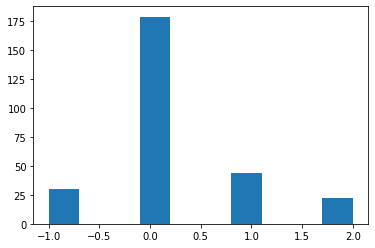

In [72]:
clusters = DBSCAN(eps=5.3, min_samples=30)
clusters_all = clusters.fit_predict(er)
clusters_train = clusters_all[rand_fold]
clusters_test = clusters_all[np.delete(np.arange(er.shape[0]), rand_fold)]
plt.hist(clusters_train)

In [73]:
clusters = DBSCAN(eps=5.3, min_samples=30)
clusters_all = clusters.fit_predict(er)
clusters_train = clusters_all[rand_fold]
clusters_test = clusters_all[np.delete(np.arange(er.shape[0]), rand_fold)]

for i in np.unique(clusters.labels_):
    mgua_model = mguaJN.MGUA(Q=20, C=0.6, I=10, model=Ridge(alpha=0.1))
    mgua_model.fit(X_train.loc[clusters_train==i], y_train.loc[clusters_train==i])
    if X_test.loc[clusters_test==i].shape[0] > 0:
        res = np.array(mgua_model.predict(X_test.loc[clusters_test==i]))
        res = res.reshape(len(mgua_model.buf_coef[0]), X_test.loc[clusters_test==i].shape[0]).mean(axis=0)
        print("CLUSTER #", i)
        print()
        print("r2 score на тестовой выборке = ", r2_score(y_test.loc[clusters_test==i], res))
        y_sgn_res = [-1 if y_i <= 0 else 1 for y_i in res]
        print()
        print(classification_report(y_test.loc[clusters_test==i], y_sgn_res))
    else:
        print("CLUSTER #", i)
        print("No elements in test")

CLUSTER # -1

r2 score на тестовой выборке =  0.10999092795227228

              precision    recall  f1-score   support

          -1       0.65      0.92      0.76        12
           1       0.80      0.40      0.53        10

    accuracy                           0.68        22
   macro avg       0.72      0.66      0.65        22
weighted avg       0.72      0.68      0.66        22



CLUSTER # 0

r2 score на тестовой выборке =  -0.03150778158320189

              precision    recall  f1-score   support

          -1       0.00      0.00      0.00        14
           1       0.80      1.00      0.89        56

    accuracy                           0.80        70
   macro avg       0.40      0.50      0.44        70
weighted avg       0.64      0.80      0.71        70



/Users/Varya/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


CLUSTER # 1

r2 score на тестовой выборке =  -0.07463842975206614

              precision    recall  f1-score   support

          -1       0.00      0.00      0.00         5
           1       0.67      1.00      0.80        10

    accuracy                           0.67        15
   macro avg       0.33      0.50      0.40        15
weighted avg       0.44      0.67      0.53        15



/Users/Varya/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


CLUSTER # 2

r2 score на тестовой выборке =  -0.2250000000000001

              precision    recall  f1-score   support

          -1       0.00      0.00      0.00         1
           1       0.91      1.00      0.95        10

    accuracy                           0.91        11
   macro avg       0.45      0.50      0.48        11
weighted avg       0.83      0.91      0.87        11



/Users/Varya/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Метод главных компонент и DBSCAN

In [74]:
pca = PCA(n_components=10)
er_pca = pd.DataFrame(pca.fit_transform(er))

train_size = int(0.7 * er_pca.shape[0])
rand_fold = random.choice(np.arange(er_pca.shape[0]).tolist(), train_size, False)
X_train = pd.DataFrame(preprocessing.scale(er_pca[:].loc[rand_fold]))
y_train = er_class_y[:].loc[rand_fold]
X_test = pd.DataFrame(preprocessing.scale(er_pca[:].loc[np.delete(np.arange(er_pca.shape[0]), rand_fold)]))
y_test = er_class_y[:].loc[np.delete(np.arange(er_pca.shape[0]), rand_fold)]

CLUSTER # -1

r2 score на тестовой выборке =  0.0467691190668067

              precision    recall  f1-score   support

          -1       0.57      0.67      0.62         6
           1       0.67      0.57      0.62         7

    accuracy                           0.62        13
   macro avg       0.62      0.62      0.62        13
weighted avg       0.62      0.62      0.62        13



CLUSTER # 0

r2 score на тестовой выборке =  -0.11252690822075095

              precision    recall  f1-score   support

          -1       0.00      0.00      0.00        13
           1       0.82      0.98      0.89        59

    accuracy                           0.81        72
   macro avg       0.41      0.49      0.45        72
weighted avg       0.67      0.81      0.73        72



CLUSTER # 1

r2 score на тестовой выборке =  0.09740386337831874

              precision    recall  f1-score   support

          -1       0.50      0.14      0.22         7
           1       0.68      0.93      0.79        14

    accuracy                           0.67        21
   macro avg       0.59      0.54      0.51        21
weighted avg       0.62      0.67      0.60        21



CLUSTER # 2

r2 score на тестовой выборке =  -3.259833787654661

              precision    recall  f1-score   support

          -1       0.18      1.00      0.31         2
           1       1.00      0.10      0.18        10

    accuracy                           0.25        12
   macro avg       0.59      0.55      0.24        12
weighted avg       0.86      0.25      0.20        12



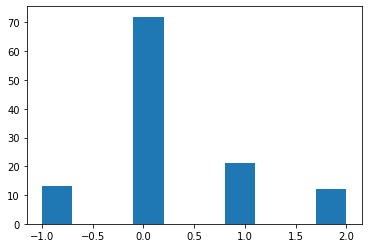

In [84]:
clusters = DBSCAN(eps=4.0, min_samples=30)
clusters_all = clusters.fit_predict(er_pca)
clusters_train = clusters_all[rand_fold]
clusters_test = clusters_all[np.delete(np.arange(er.shape[0]), rand_fold)]
plt.hist(clusters_test)

for i in np.unique(clusters.labels_):
    mgua_model = mguaJN.MGUA(Q=20, C=0.6, I=10, model=Ridge(alpha=0.1))
    mgua_model.fit(X_train.loc[clusters_train==i], y_train.loc[clusters_train==i])
    if X_test.loc[clusters_test==i].shape[0] > 0:
        res = np.array(mgua_model.predict(X_test.loc[clusters_test==i]))
        res = res.reshape(len(mgua_model.buf_coef[0]), X_test.loc[clusters_test==i].shape[0]).mean(axis=0)
        print("CLUSTER #", i)
        print()
        print("r2 score на тестовой выборке = ", r2_score(y_test.loc[clusters_test==i], res))
        y_sgn_res = [-1 if y_i <= 0 else 1 for y_i in res]
        print()
        print(classification_report(y_test.loc[clusters_test==i], y_sgn_res))
    else:
        print("CLUSTER #", i)
        print("No elements in test")

## Выборка er_lit NNd**_UpTo3chains

In [85]:
er = pd.read_csv('er_lit/er_lit_matrix_alphabet_NNd**_UpTo3chains.csv', sep=',')
er_y = pd.read_csv('er_lit/er_lit_y.csv', sep=',')

In [86]:
normalized_er = preprocessing.normalize(er)
normalized_er.shape

(393, 137)

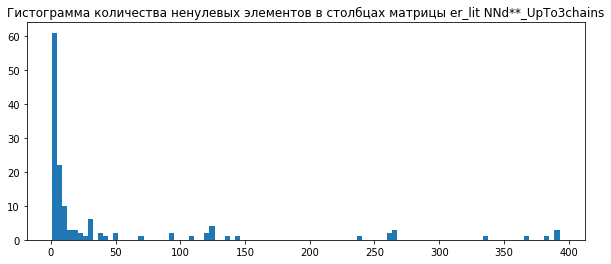

In [228]:
num_nonzero_col = []
for i in range(normalized_er.shape[1]):
    num_nonzero_col.append(normalized_er[:, i].nonzero()[0].shape[0])
plt.figure(figsize=(10,4))
plt.title("Гистограмма количества ненулевых элементов в столбцах матрицы er_lit NNd**_UpTo3chains")
_ = plt.hist(num_nonzero_col, bins=100)

In [229]:
mask = np.array(num_nonzero_col) == 1
print("количество столбцов с одним ненулевым элементом = ", mask.sum(), "/", (~mask).sum())

количество столбцов с одним ненулевым элементом =  33 / 104


### Нормализация y
вычтем из y активность: для выборки er_lit - это 1.0

In [87]:
er_y = er_y - 1.0

In [231]:
mgua_model = mguaJN.MGUA(Q=20, C=0.6, I=10, model=Ridge(alpha=0.1))

In [232]:
train_size = int(0.7 * er.shape[0])
X_train = pd.DataFrame(preprocessing.scale(er[:][:train_size]))
y_train = er_y[:][:train_size]
X_test = pd.DataFrame(preprocessing.scale(er[:][train_size:]))
y_test = er_y[:][train_size:]
mgua_model.fit(X_train, y_train)
res = np.array(mgua_model.predict(X_test))
res_train = np.array(mgua_model.predict(X_train))
res = res.reshape(len(mgua_model.buf_coef[0]), X_test.shape[0]).mean(axis=0)
res_train = res_train.reshape(len(mgua_model.buf_coef[0]), X_train.shape[0]).mean(axis=0)
print("r2 score на тестовой выборке = ", r2_score(y_test, res))
print("r2 score на тренировочной выборке = ", r2_score(y_train, res_train))

r2 score на тестовой выборке =  -0.25294006832337734
r2 score на тренировочной выборке =  0.038225885121560665


In [233]:
y_np_test = y_test.to_numpy().reshape(-1)
y_sgn_test = [-1 if y_i <= 0 else 1 for y_i in y_np_test]
y_sgn_res = [-1 if y_i <= 0 else 1 for y_i in res]
print(classification_report(y_sgn_test, y_sgn_res))
print("roc_auc_score = ", roc_auc_score(y_sgn_test, y_sgn_res))

              precision    recall  f1-score   support

          -1       0.00      0.00      0.00        32
           1       0.73      1.00      0.84        86

    accuracy                           0.73       118
   macro avg       0.36      0.50      0.42       118
weighted avg       0.53      0.73      0.61       118

roc_auc_score =  0.5


/Users/Varya/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Подадим в МГУА ответы для классификации:

In [234]:
er_np_y = er_y.to_numpy().reshape(-1)
er_class_y = pd.DataFrame([-1 if y_i <= 0 else 1 for y_i in er_np_y])

In [235]:
# train_size = int(0.7 * er.shape[0])
rand_fold = random.choice(np.arange(er.shape[0]).tolist(), train_size, False)
X_train = pd.DataFrame(preprocessing.scale(er[:].loc[rand_fold]))
y_train = er_class_y[:].loc[rand_fold]
X_test = pd.DataFrame(preprocessing.scale(er[:].loc[np.delete(np.arange(er.shape[0]), rand_fold)]))
y_test = er_class_y[:].loc[np.delete(np.arange(er.shape[0]), rand_fold)]
# X_train = pd.DataFrame(preprocessing.scale(bzr[:][:train_size]))
# y_train = bzr_class_y[:][:train_size]
# X_test = pd.DataFrame(preprocessing.scale(bzr[:][train_size:]))
# y_test = bzr_class_y[:][train_size:]
mgua_model.fit(X_train, y_train)
res = np.array(mgua_model.predict(X_test))
# res_train = np.array(mgua_model.predict(X_train))
res = res.reshape(res.shape[0], res.shape[1]).mean(axis=0)
# res_train = res_train.reshape(len(mgua_model.buf_coef[0]), X_train.shape[0]).mean(axis=0)
print("r2 score на тестовой выборке = ", r2_score(y_test, res))
# print("r2 score на тренировочной выборке = ", r2_score(y_train, res_train))
y_sgn_res = [-1 if y_i <= 0 else 1 for y_i in res]
print()
print(classification_report(y_test, y_sgn_res))
print()
print("roc_auc_score = ", roc_auc_score(y_test, y_sgn_res))

r2 score на тестовой выборке =  -0.06586530270939872

              precision    recall  f1-score   support

          -1       0.00      0.00      0.00        34
           1       0.71      1.00      0.83        84

    accuracy                           0.71       118
   macro avg       0.36      0.50      0.42       118
weighted avg       0.51      0.71      0.59       118


roc_auc_score =  0.5


/Users/Varya/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Кластеризация


In [88]:
er_np_y = er_y.to_numpy().reshape(-1)
er_class_y = pd.DataFrame([-1 if y_i <= 0 else 1 for y_i in er_np_y])

In [89]:
train_size = int(0.7 * er.shape[0])
rand_fold = random.choice(np.arange(er.shape[0]).tolist(), train_size, False)
X_train = pd.DataFrame(preprocessing.scale(er[:].loc[rand_fold]))
y_train = er_class_y[:].loc[rand_fold]
X_test = pd.DataFrame(preprocessing.scale(er[:].loc[np.delete(np.arange(er.shape[0]), rand_fold)]))
y_test = er_class_y[:].loc[np.delete(np.arange(er.shape[0]), rand_fold)]

### Кластеризация с помощью метода к-средних


In [90]:
k = 3
min_elem_in_cluster = 25
clusters = KMeans(n_clusters=k)
clusters_train = clusters.fit_predict(X_train)

is_good_clusters = False
while is_good_clusters == False:
    clusters_train = clusters.fit_predict(X_train)
    elems_in_clusters = np.array([np.array([clusters_train == i]).sum() for i in np.unique(clusters_train)])
    elems_in_clusters_bool = elems_in_clusters > min_elem_in_cluster
    is_good_clusters = np.all(elems_in_clusters_bool)
print('Founded good clusters:', elems_in_clusters)
print()
clusters_test = clusters.predict(X_test)

for i in range(k):
    mgua_model = mguaJN.MGUA(Q=20, C=0.6, I=10, model=Ridge(alpha=0.1))
    mgua_model.fit(X_train.loc[clusters_train==i], y_train.loc[clusters_train==i])
    if X_test.loc[clusters_test==i].shape[0] > 0:
        res = np.array(mgua_model.predict(X_test.loc[clusters_test==i]))
        res = res.reshape(len(mgua_model.buf_coef[0]), X_test.loc[clusters_test==i].shape[0]).mean(axis=0)
        print("CLUSTER #", i)
        print()
        print("r2 score на тестовой выборке = ", r2_score(y_test.loc[clusters_test==i], res))
        y_sgn_res = [-1 if y_i <= 0 else 1 for y_i in res]
        print()
        print(classification_report(y_test.loc[clusters_test==i], y_sgn_res))
    else:
        print("CLUSTER #", i)
        print("No elements in test")

Founded good clusters: [88 96 91]



CLUSTER # 0

r2 score на тестовой выборке =  -0.19854604116927077

              precision    recall  f1-score   support

          -1       0.00      0.00      0.00        18
           1       0.55      1.00      0.71        22

    accuracy                           0.55        40
   macro avg       0.28      0.50      0.35        40
weighted avg       0.30      0.55      0.39        40



/Users/Varya/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


CLUSTER # 1

r2 score на тестовой выборке =  -0.0034587900128624227

              precision    recall  f1-score   support

          -1       0.00      0.00      0.00         2
           1       0.93      1.00      0.96        27

    accuracy                           0.93        29
   macro avg       0.47      0.50      0.48        29
weighted avg       0.87      0.93      0.90        29



/Users/Varya/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


CLUSTER # 2

r2 score на тестовой выборке =  -5.919582714453142e-06

              precision    recall  f1-score   support

          -1       0.00      0.00      0.00        13
           1       0.73      1.00      0.85        36

    accuracy                           0.73        49
   macro avg       0.37      0.50      0.42        49
weighted avg       0.54      0.73      0.62        49



/Users/Varya/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Кластеризация с помощью метода DBSCAN

In [121]:
train_size = int(0.7 * er.shape[0])
rand_fold = random.choice(np.arange(er.shape[0]).tolist(), train_size, False)
X_train = pd.DataFrame(preprocessing.scale(er[:].loc[rand_fold]))
y_train = er_class_y[:].loc[rand_fold]
X_test = pd.DataFrame(preprocessing.scale(er[:].loc[np.delete(np.arange(er.shape[0]), rand_fold)]))
y_test = er_class_y[:].loc[np.delete(np.arange(er.shape[0]), rand_fold)]

(array([135.,   0.,   0.,   0.,   0.,  78.,   0.,   0.,   0.,  62.]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]),
 <a list of 10 Patch objects>)

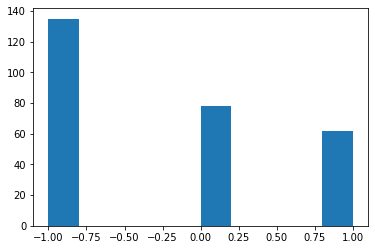

In [122]:
clusters = DBSCAN(eps=3.8, min_samples=30)
clusters_all = clusters.fit_predict(er)
clusters_train = clusters_all[rand_fold]
clusters_test = clusters_all[np.delete(np.arange(er.shape[0]), rand_fold)]
plt.hist(clusters_train)

In [100]:
clusters = DBSCAN(eps=3.8, min_samples=30)
clusters_all = clusters.fit_predict(er)
clusters_train = clusters_all[rand_fold]
clusters_test = clusters_all[np.delete(np.arange(er.shape[0]), rand_fold)]

for i in np.unique(clusters.labels_):
    mgua_model = mguaJN.MGUA(Q=20, C=0.6, I=10, model=Ridge(alpha=0.1))
    mgua_model.fit(X_train.loc[clusters_train==i], y_train.loc[clusters_train==i])
    if X_test.loc[clusters_test==i].shape[0] > 0:
        res = np.array(mgua_model.predict(X_test.loc[clusters_test==i]))
        res = res.reshape(len(mgua_model.buf_coef[0]), X_test.loc[clusters_test==i].shape[0]).mean(axis=0)
        print("CLUSTER #", i)
        print()
        print("r2 score на тестовой выборке = ", r2_score(y_test.loc[clusters_test==i], res))
        y_sgn_res = [-1 if y_i <= 0 else 1 for y_i in res]
        print()
        print(classification_report(y_test.loc[clusters_test==i], y_sgn_res))
    else:
        print("CLUSTER #", i)
        print("No elements in test")

CLUSTER # -1

r2 score на тестовой выборке =  -0.036557271803918656

              precision    recall  f1-score   support

          -1       0.00      0.00      0.00        14
           1       0.76      0.98      0.85        45

    accuracy                           0.75        59
   macro avg       0.38      0.49      0.43        59
weighted avg       0.58      0.75      0.65        59



CLUSTER # 0

r2 score на тестовой выборке =  -0.0071118966460463895

              precision    recall  f1-score   support

          -1       0.00      0.00      0.00         8
           1       0.75      1.00      0.86        24

    accuracy                           0.75        32
   macro avg       0.38      0.50      0.43        32
weighted avg       0.56      0.75      0.64        32



/Users/Varya/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


CLUSTER # 1

r2 score на тестовой выборке =  0.0

              precision    recall  f1-score   support

           1       1.00      1.00      1.00        27

    accuracy                           1.00        27
   macro avg       1.00      1.00      1.00        27
weighted avg       1.00      1.00      1.00        27



### Метод главных компонент и DBSCAN

In [101]:
pca = PCA(n_components=10)
er_pca = pd.DataFrame(pca.fit_transform(er))

train_size = int(0.7 * er_pca.shape[0])
rand_fold = random.choice(np.arange(er_pca.shape[0]).tolist(), train_size, False)
X_train = pd.DataFrame(preprocessing.scale(er_pca[:].loc[rand_fold]))
y_train = er_class_y[:].loc[rand_fold]
X_test = pd.DataFrame(preprocessing.scale(er_pca[:].loc[np.delete(np.arange(er_pca.shape[0]), rand_fold)]))
y_test = er_class_y[:].loc[np.delete(np.arange(er_pca.shape[0]), rand_fold)]

CLUSTER # -1

r2 score на тестовой выборке =  0.09862590561132767

              precision    recall  f1-score   support

          -1       0.50      0.17      0.25        12
           1       0.73      0.93      0.82        29

    accuracy                           0.71        41
   macro avg       0.61      0.55      0.53        41
weighted avg       0.66      0.71      0.65        41



CLUSTER # 0

r2 score на тестовой выборке =  -0.09915836051163973

              precision    recall  f1-score   support

          -1       0.00      0.00      0.00        10
           1       0.85      1.00      0.92        58

    accuracy                           0.85        68
   macro avg       0.43      0.50      0.46        68
weighted avg       0.73      0.85      0.79        68



/Users/Varya/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


CLUSTER # 1

r2 score на тестовой выборке =  0.0

              precision    recall  f1-score   support

          -1       0.00      0.00      0.00         0
           1       1.00      0.89      0.94         9

    accuracy                           0.89         9
   macro avg       0.50      0.44      0.47         9
weighted avg       1.00      0.89      0.94         9



/Users/Varya/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


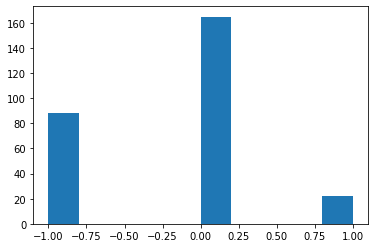

In [120]:
clusters = DBSCAN(eps=3.4, min_samples=30)
clusters_all = clusters.fit_predict(er_pca)
clusters_train = clusters_all[rand_fold]
clusters_test = clusters_all[np.delete(np.arange(er.shape[0]), rand_fold)]
plt.hist(clusters_train)

for i in np.unique(clusters.labels_):
    mgua_model = mguaJN.MGUA(Q=20, C=0.6, I=10, model=Ridge(alpha=0.1))
    mgua_model.fit(X_train.loc[clusters_train==i], y_train.loc[clusters_train==i])
    if X_test.loc[clusters_test==i].shape[0] > 0:
        res = np.array(mgua_model.predict(X_test.loc[clusters_test==i]))
        res = res.reshape(len(mgua_model.buf_coef[0]), X_test.loc[clusters_test==i].shape[0]).mean(axis=0)
        print("CLUSTER #", i)
        print()
        print("r2 score на тестовой выборке = ", r2_score(y_test.loc[clusters_test==i], res))
        y_sgn_res = [-1 if y_i <= 0 else 1 for y_i in res]
        print()
        print(classification_report(y_test.loc[clusters_test==i], y_sgn_res))
    else:
        print("CLUSTER #", i)
        print("No elements in test")